In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import json 

In [3]:
def calculate_differences(values):
    differences = [values[i + 1] - values[i] for i in range(len(values) - 1)]
    return differences

In [4]:
def find_max_difference(values):
    if len(values) < 2:
        return None, None  
    
    differences = calculate_differences(values)
    max_diff = max(differences)
    max_index = differences.index(max_diff)
    return max_diff, max_index

In [5]:
def find_stable_jumps(y, jump_threshold=0.5, drop_threshold=0.2, stability_range=10, tolerance=2):
    valid_jumps = []
    violation_detected = False  # Flag to check if any violation occurs
    jump_detected = False  # Flag to check if any jump meets the threshold
    for i in range(1, len(y)):
        if y[i] >= y[i-1] + jump_threshold:
            jump_detected = True  # Set flag on first jump that meets the threshold
            post_jump_values = y[i:min(len(y), i + stability_range)]
            violations = sum(1 for val in post_jump_values if val < y[i] - drop_threshold)
            if violations <= tolerance:
                valid_jumps.append((i, y[i]))
    return valid_jumps, jump_detected

In [6]:
def plot_data(samples, title):
    for sample in samples:
        plt.figure()
        plt.plot(sample['sum_mult_list'], marker='o', linestyle='-')
        plt.title(f"{title} - {sample['protein_name']}_{sample['position']}\nMax Diff: {sample['max_diff']} at index {sample['max_index']}")
        plt.xlabel('Index')
        plt.ylabel('sum_mult_list')
        plt.grid(True)
        plt.ylim(0, 1.3) 
        plt.xlim(0, 100)
        plt.show()

In [7]:
count_total_cases = 0 
count_started_high = 0 
count_low_max = 0
count_significant_jumps = 0
all_info = []
protein_nofluc = []
unselected_cases = []
started_high = []
low_max = []
with h5py.File('/data/zhzhang/062023_pnas_revision/single_resample/single_wo_bos_eos.hdf5', 'r') as f:
    protein_names = list(f.keys())
    for protein_name in tqdm(protein_names):
        positions = list(f[protein_name].keys())
        count_total_cases += len(positions) 
        for position in positions:
            flank_lens = sorted([int(x) for x in f[f"{protein_name}/{position}"].keys()])
            sum_mult_list = [f[f"{protein_name}/{position}/{fl}/sum_mult"][()] for fl in flank_lens]

            if max(sum_mult_list) <= 0.5:
                count_low_max += 1
                low_max.append({
                    'protein_name': protein_name,
                    'position': position,
                }) 
                continue
                
            max_diff, max_index = find_max_difference(sum_mult_list)
            if max_diff is None or max_index is None:
                continue
                
            all_info.append({
                    'protein_name': protein_name,
                    'position': position,
                    'sum_mult_list': [float(x) for x in sum_mult_list],
                    'max_diff': float(max_diff),
                    'max_index': max_index
                })
            
            if sum_mult_list[0] > 0.5: 
                count_started_high +=1
                started_high.append({
                    'protein_name': protein_name,
                    'position': position,
                })
                    
            
            valid_jumps, jump_detected = find_stable_jumps(sum_mult_list)

            if jump_detected:
                count_significant_jumps += 1  # Increment if any jump meets the threshold

            if valid_jumps:
                protein_nofluc.append({
                    'protein_name': protein_name,
                    'position': position,
                    'sum_mult_list': [float(x) for x in sum_mult_list],
                    'max_diff': float(valid_jumps[0][1]),
                    'max_index': valid_jumps[0][0]
                })
            else:
                unselected_cases.append({
                    'protein_name': protein_name,
                    'position': position,
                    'sum_mult_list': [float(x) for x in sum_mult_list],
                    'max_diff': float(max_diff),
                    'max_index': max_index
                })
print("Total cases processed:", count_total_cases)
print("Cases filtered out due to max(sum_mult_list) <= 0.5:", count_low_max)
print("Cases with max(sum_mult_list) > 0.5:", count_total_cases - count_low_max) 
print("Cases with at least one significant jump:", count_significant_jumps)
print("Cases with jump and maintain", len(protein_nofluc))
print("Cases not selected due to no jump or too much fluctuation", len(unselected_cases))
print("Cases started with high recovery", count_started_high)

100%|██████████| 1429/1429 [00:55<00:00, 25.73it/s]


Total cases processed: 4022
Cases filtered out due to max(sum_mult_list) <= 0.5: 758
Cases with max(sum_mult_list) > 0.5: 3264
Cases with at least one significant jump: 2690
Cases with jump and maintain 2625
Cases not selected due to no jump or too much fluctuation 637
Cases started with high recovery 78


In [8]:
with open('../data/jump_analysis/short_dist_all_reachedrecovery.json', 'w') as json_file:
    json.dump(all_info, json_file)

with open('../data/jump_analysis/short_dist_selected_jump.json', 'w') as json_file:
    json.dump(protein_nofluc, json_file)

with open('../data/jump_analysis/short_dist_unselected.json', 'w') as json_file:
    json.dump(unselected_cases, json_file)

with open('../data/jump_analysis/short_dist_started_high.json', 'w') as json_file:
    json.dump(started_high, json_file)
    
with open('../data/jump_analysis/short_dist_low_max.json', 'w') as json_file:
    json.dump(low_max, json_file)

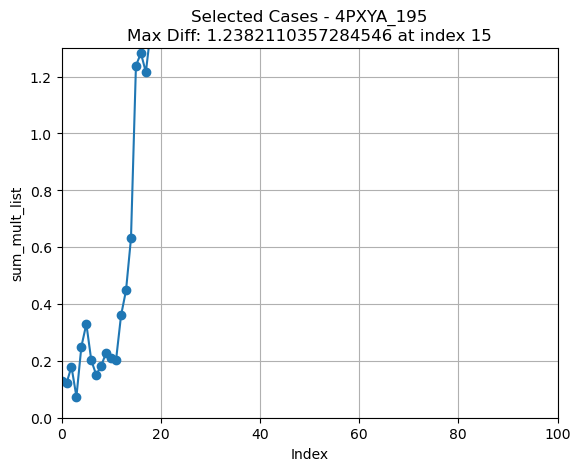

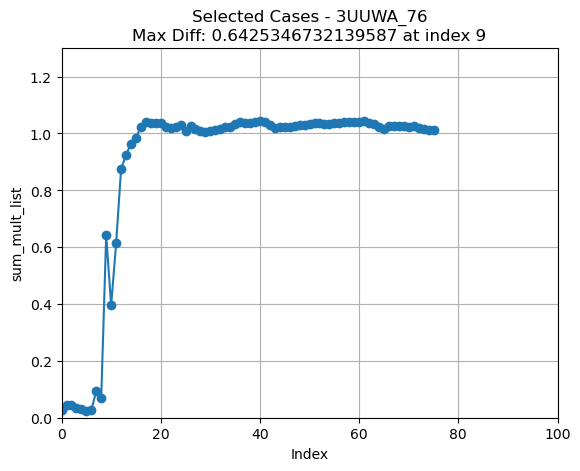

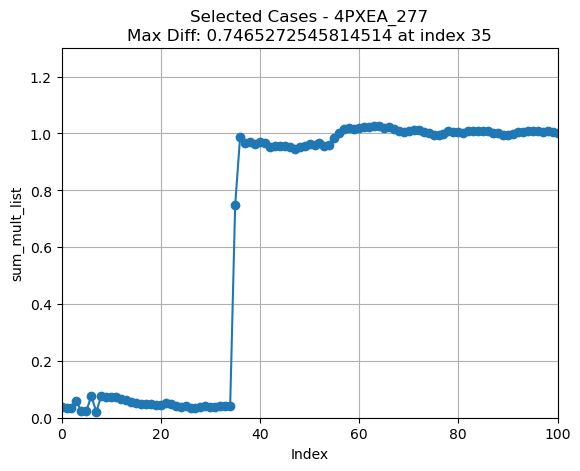

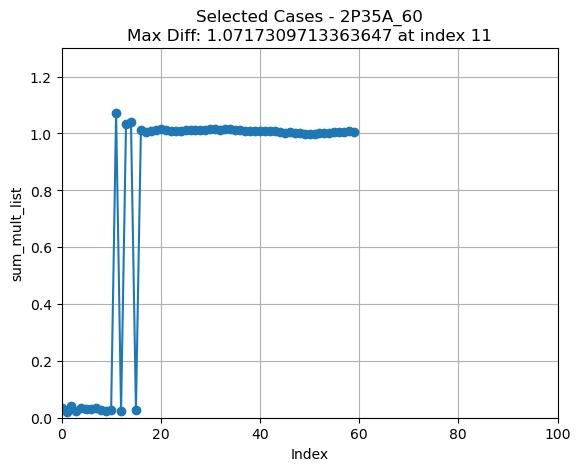

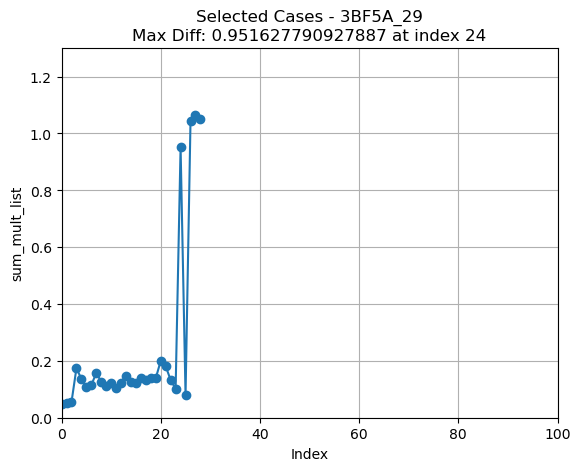

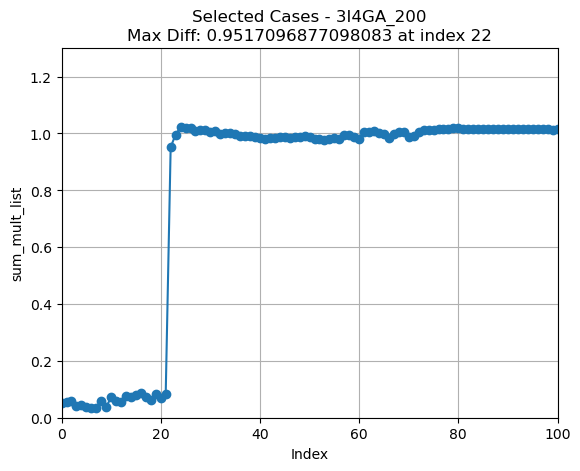

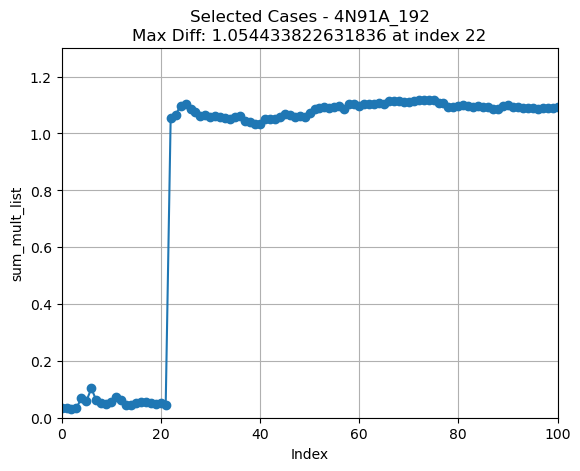

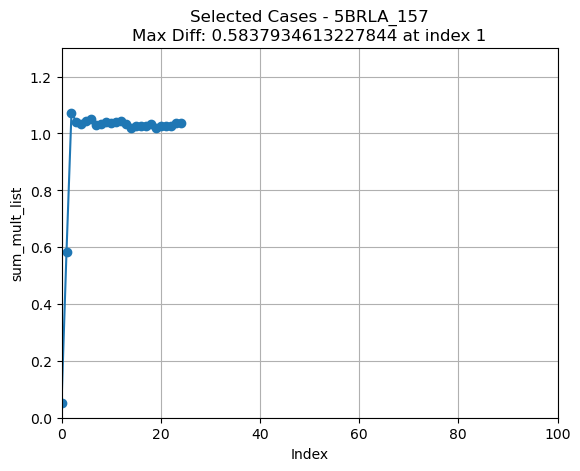

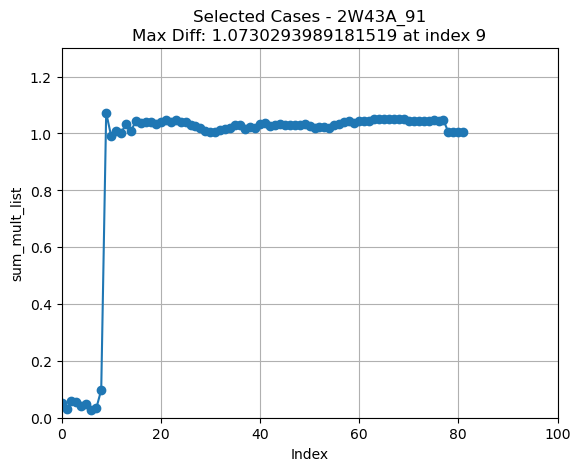

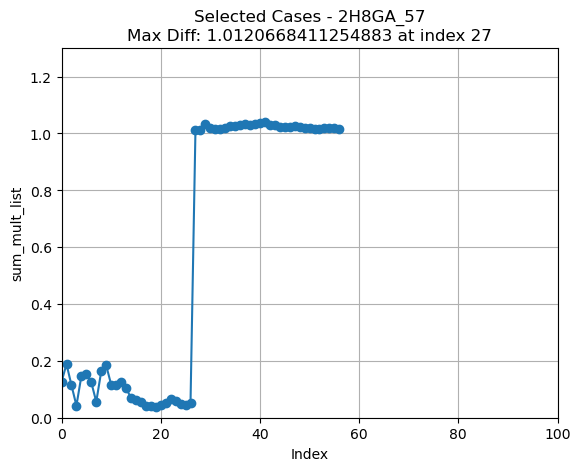

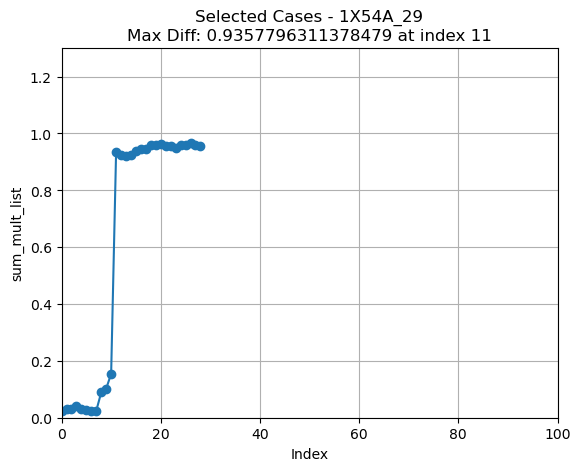

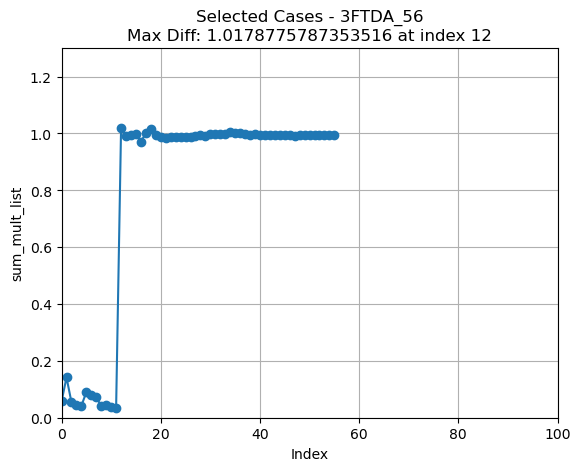

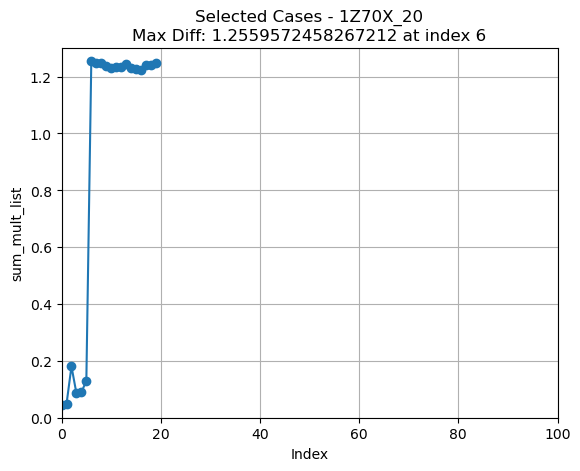

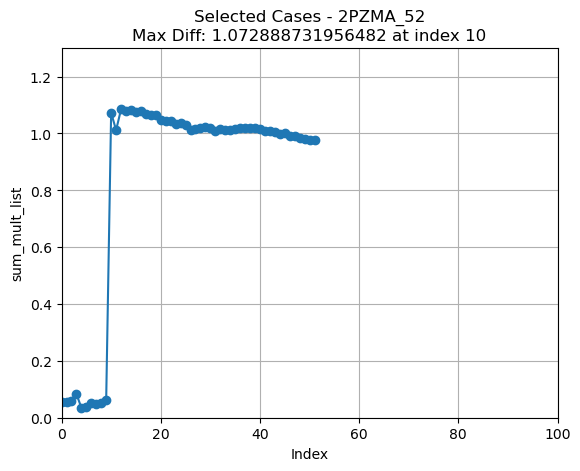

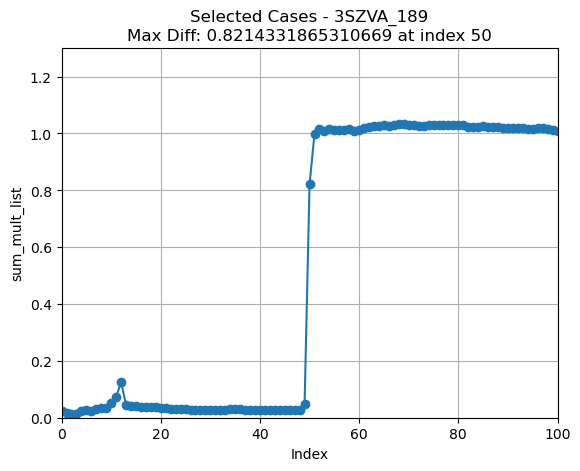

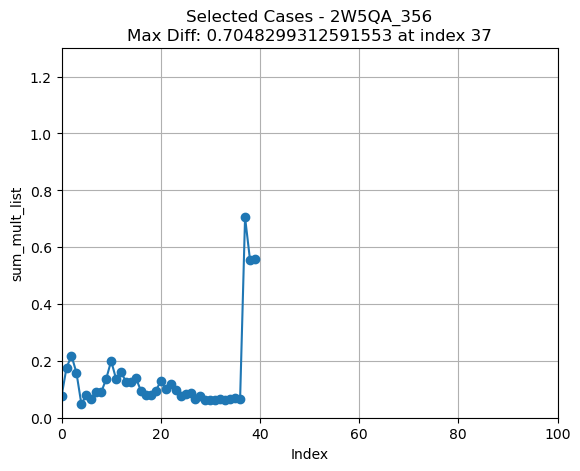

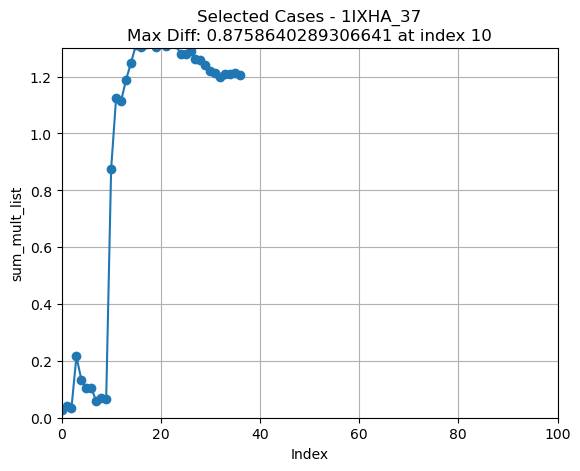

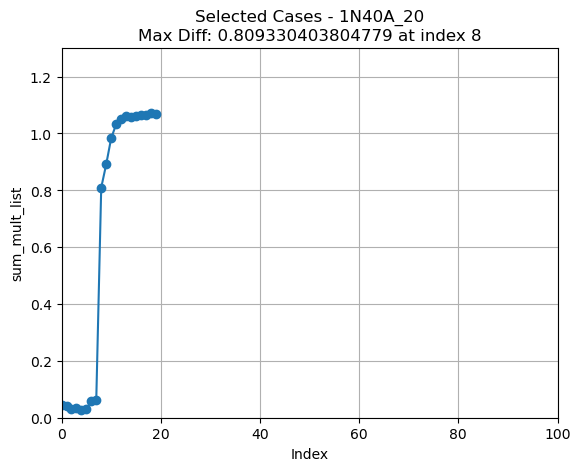

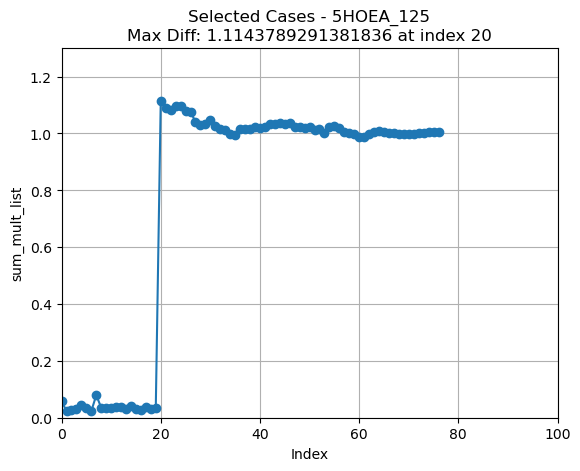

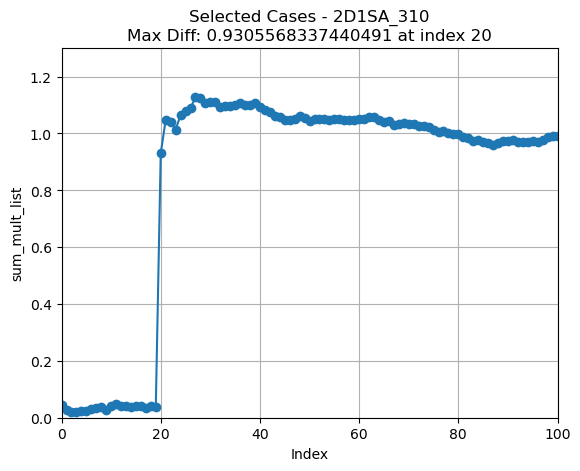

In [9]:
selected_samples = random.sample(protein_nofluc, min(len(protein_nofluc), 20))
plot_data(selected_samples, "Selected Cases")

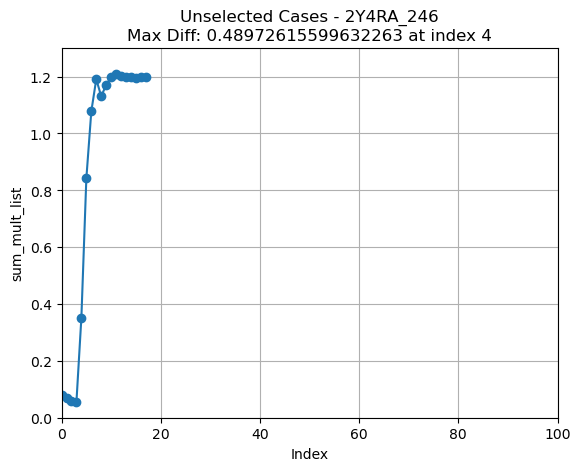

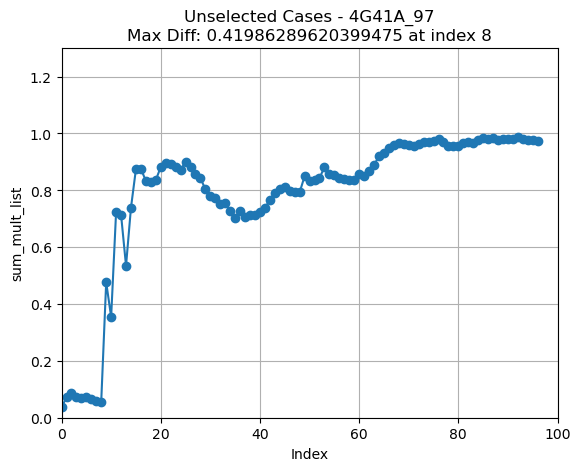

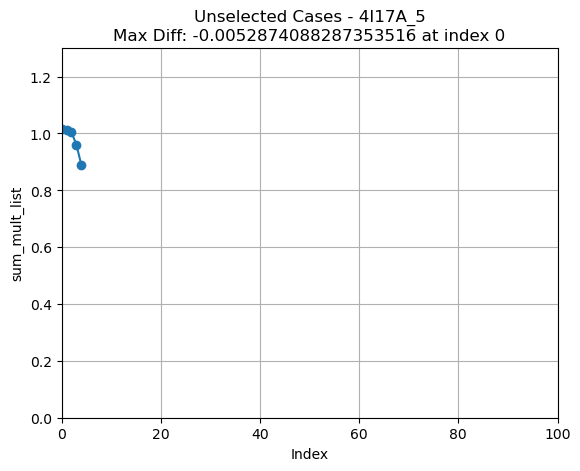

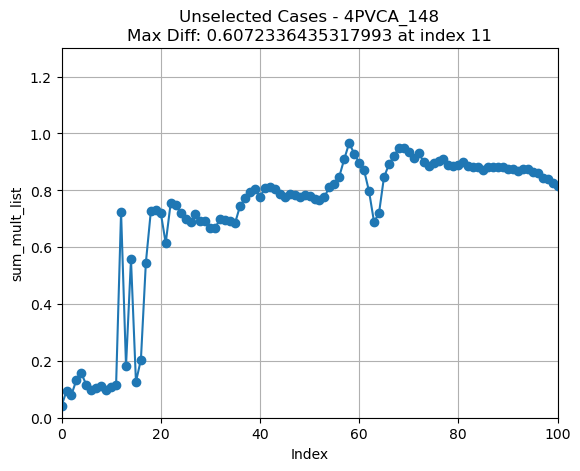

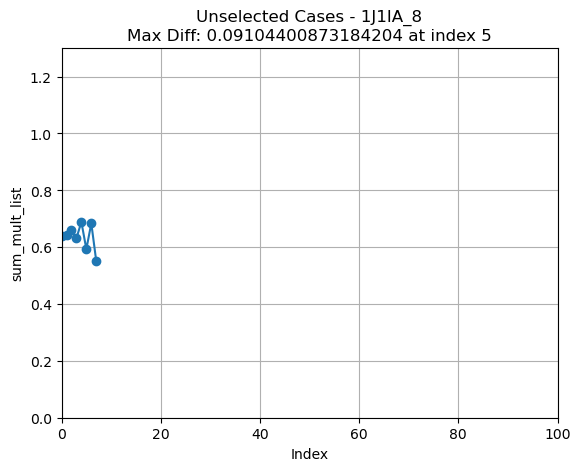

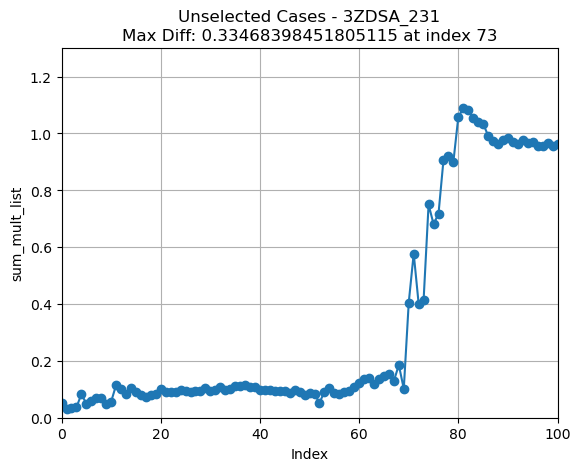

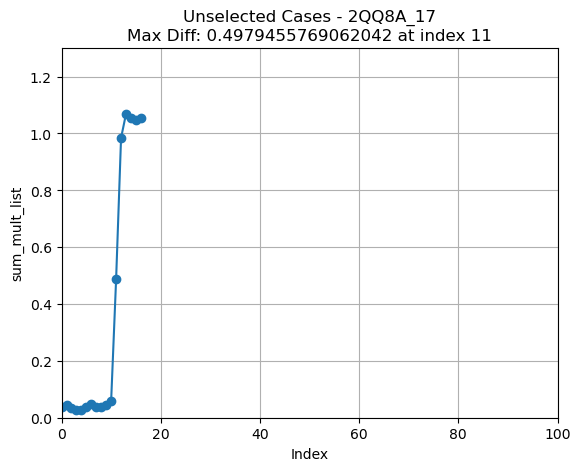

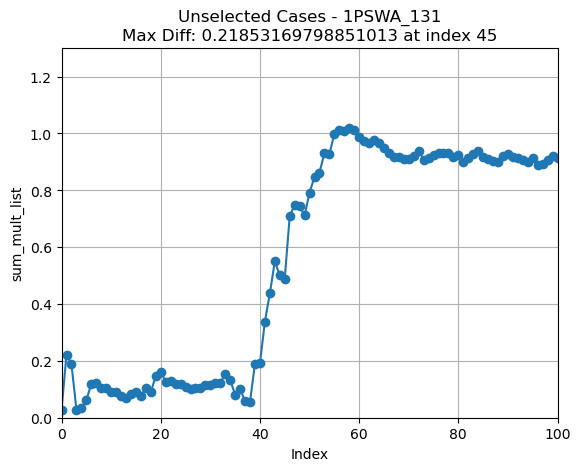

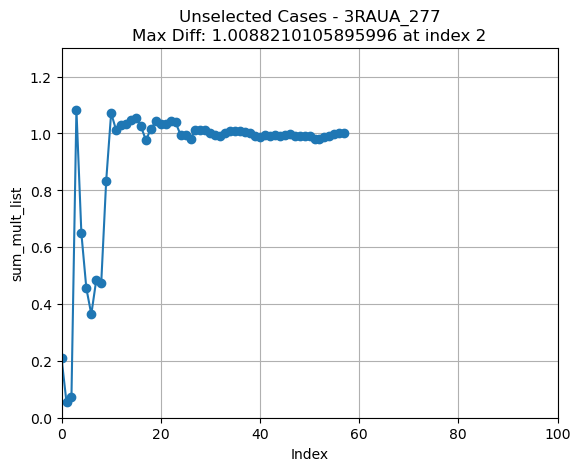

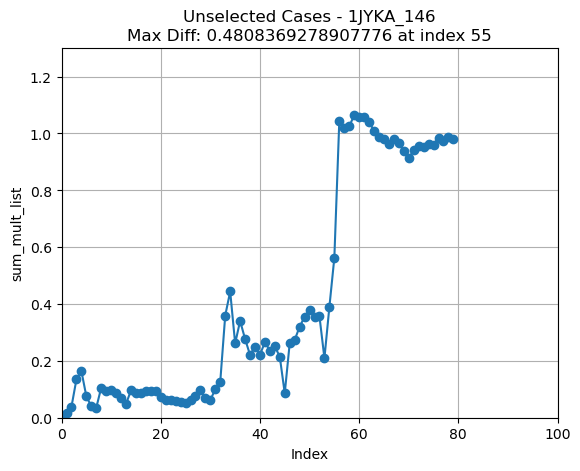

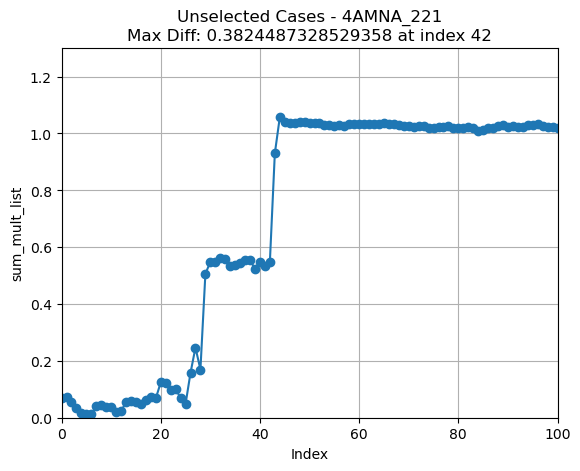

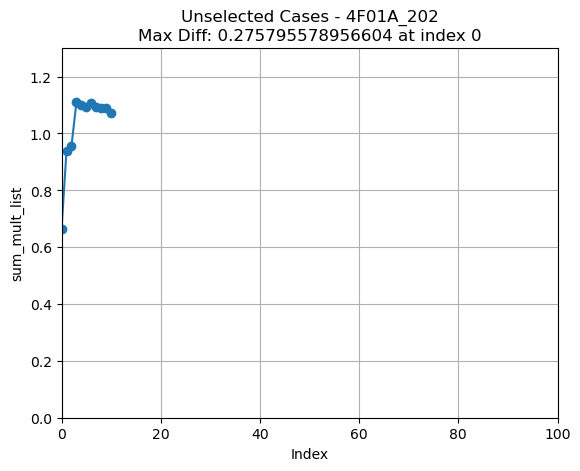

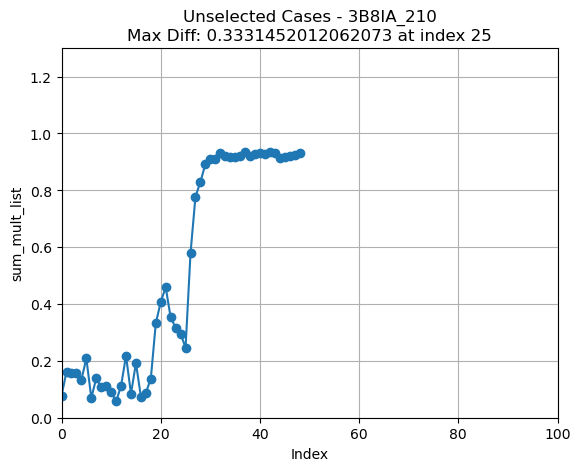

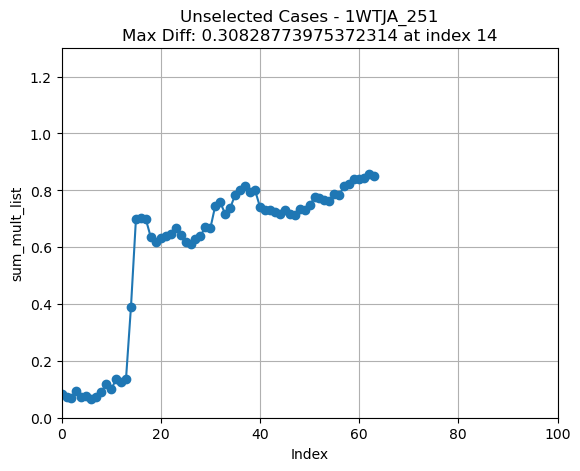

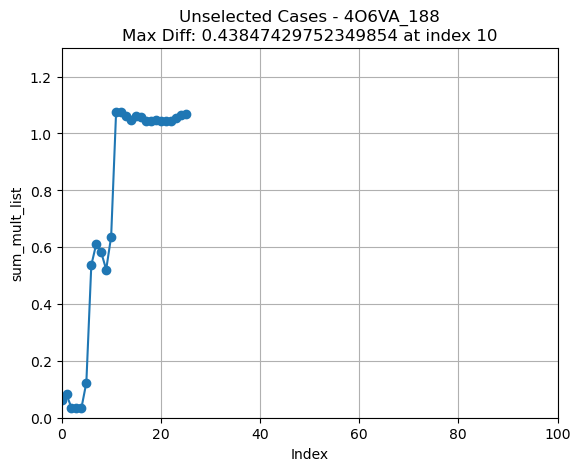

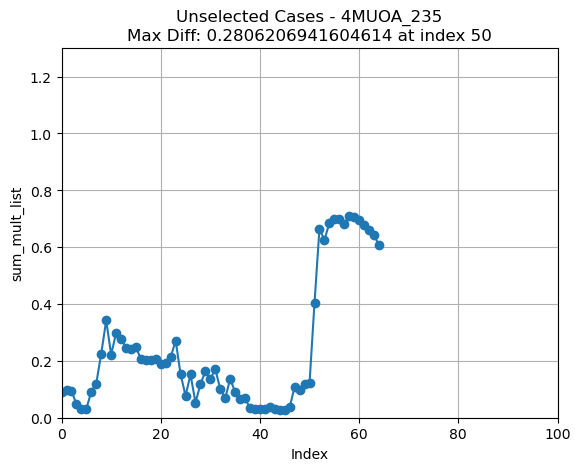

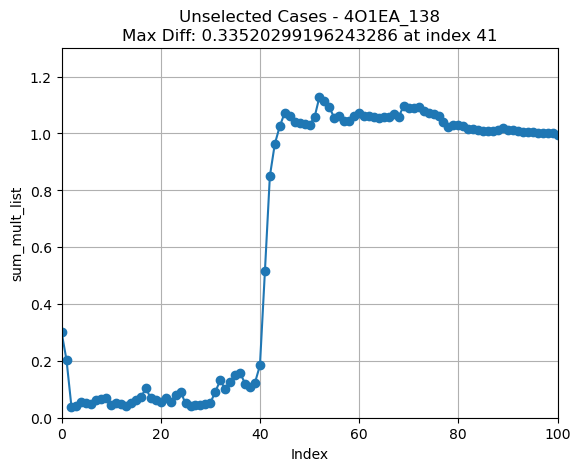

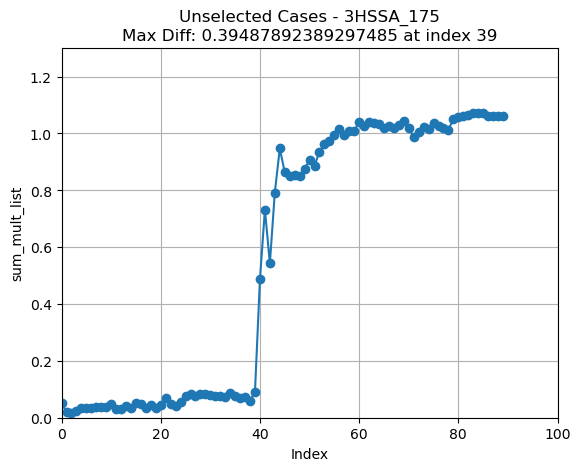

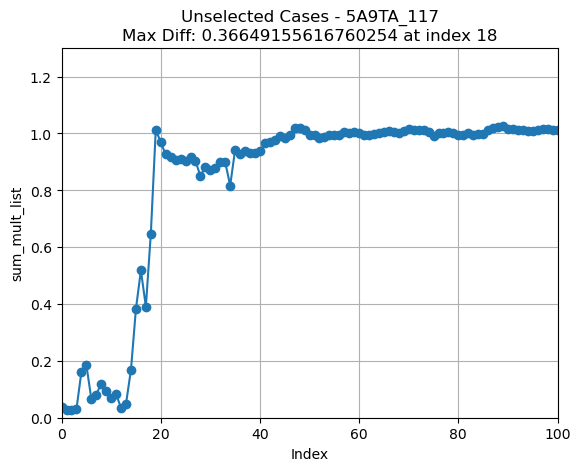

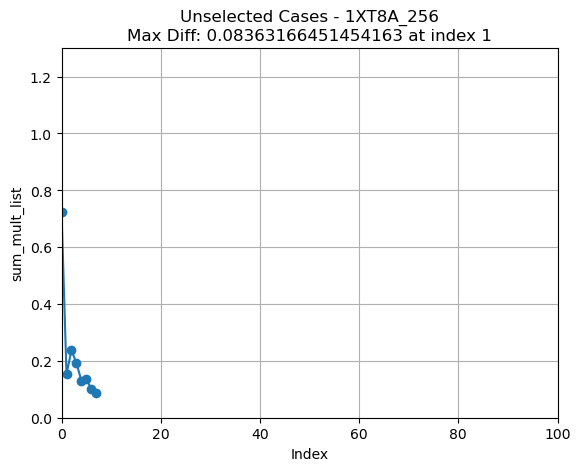

In [10]:
unselected_samples = random.sample(unselected_cases, min(len(unselected_cases), 20))
plot_data(unselected_samples, "Unselected Cases")